In [1]:
import sys
sys.path.append('../../MembraneQuant')
from membranequant import *
%matplotlib notebook

In [2]:
path = '/Users/blandt/Desktop/Data/PH RING/Experiment 1 mos/'
paths = direcslist(path, 2)
lines = [p.strip('/').split('/')[-2].split('_')[1] for p in paths]
conditions = [p.strip('/').split('/')[-2].split('_')[2] for p in paths]

imgs = [load_image(p + '/af_corrected.tif') for p in paths]
rois = [np.loadtxt(p + '/ROI_fit.txt') for p in paths]
cytbg = np.loadtxt('../T2A/cytbg.txt')
membg = np.loadtxt('../PAR2 RING MUTANTS/mem_profile.txt')

In [3]:
iq = ImageQuant(img=imgs, cytbg=cytbg, membg=membg, roi=rois, uni_cyt=True, descent_steps=400, iterations=1, 
                rol_ave=10, lr=0.01, interp_type='linear')
iq.run()

100%|██████████| 400/400 [00:39<00:00, 10.25it/s]


Time elapsed: 40.10 seconds 


<IPython.core.display.Javascript object>


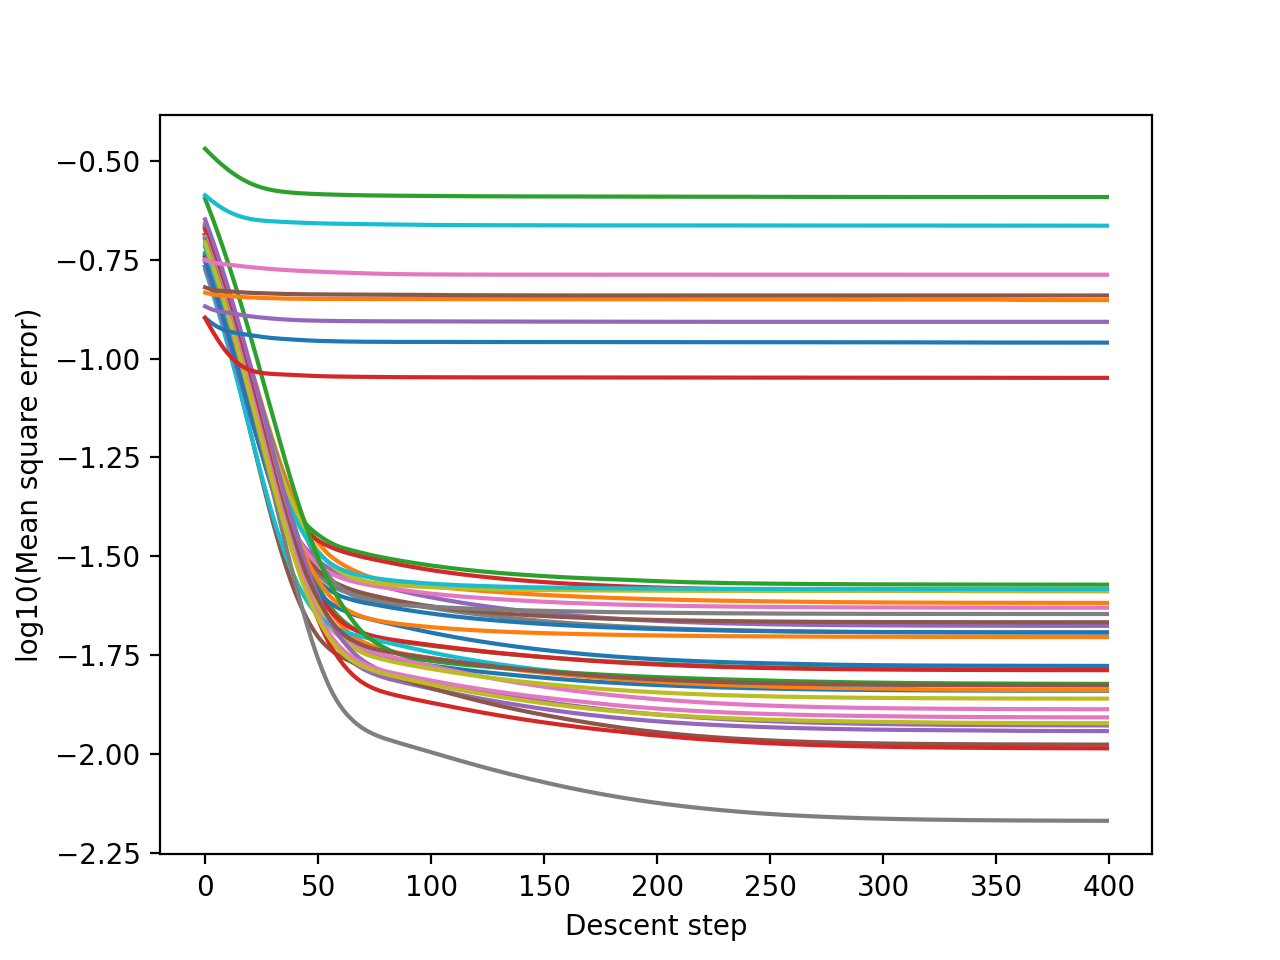

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:xlabel='Descent step', ylabel='log10(Mean square error)'>)

In [4]:
iq.plot_losses(log=True)

<IPython.core.display.Javascript object>


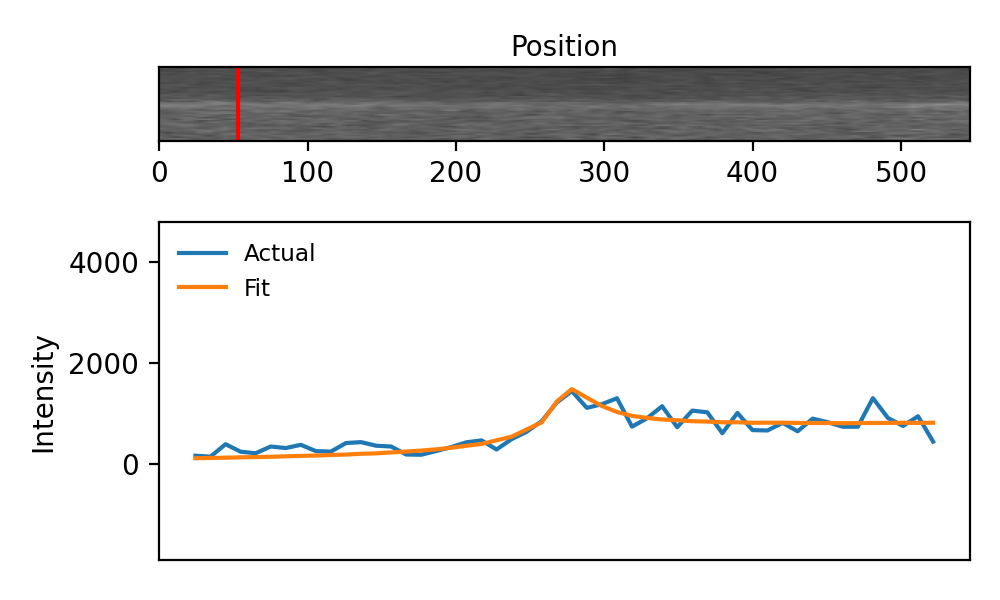

interactive(children=(IntSlider(value=0, description='Frame', max=36), FloatSlider(value=0.1, description='Pos…

(<Figure size 500x300 with 2 Axes>,
 (<AxesSubplot:xlabel='Position'>, <AxesSubplot:ylabel='Intensity'>))

In [5]:
iq.plot_fits(jupyter=True)

<IPython.core.display.Javascript object>


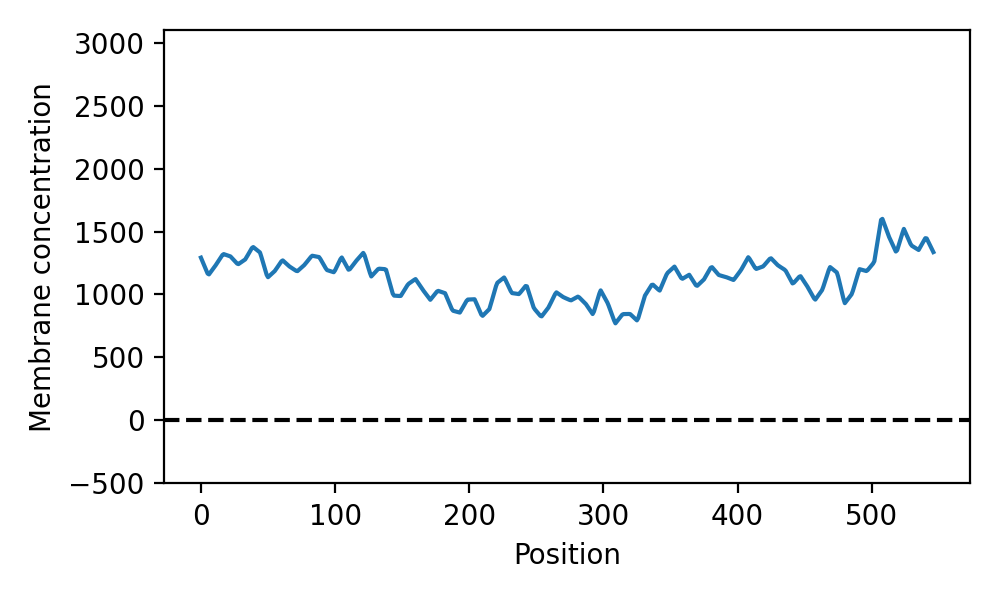

interactive(children=(IntSlider(value=0, description='Frame', max=36), Output()), _dom_classes=('widget-intera…

(<Figure size 500x300 with 1 Axes>,
 <AxesSubplot:xlabel='Position', ylabel='Membrane concentration'>)

In [6]:
iq.plot_quantification(jupyter=True)

### Compile results

In [16]:
res = iq.compile_res()
res['Membrane signal'] = res['Membrane signal'] * 2.8893596260583494
res.to_csv('res.csv')

In [18]:
res = pd.read_csv('res.csv')
cyts = res.groupby('Frame').apply(lambda x: np.mean(x['Cytoplasmic signal']))
mems_tot = res.groupby('Frame').apply(lambda x: np.mean(x['Membrane signal'])) 
mems_ant = res.groupby('Frame').apply(lambda x: bounded_mean_1d(x['Membrane signal'], (0.25, 0.75))) 
mems_post = res.groupby('Frame').apply(lambda x: bounded_mean_1d(x['Membrane signal'], (0.75, 0.25))) 
asis = [(p - a) / (a + p) for a, p in zip(mems_ant, mems_post)]
dosages = [dosage(i, r, 5) for i, r in zip(imgs, rois)]
totals = cyts + 0.174 * mems_tot
   
df_dict = {'Path': paths, 'Line': lines, 'Condition': conditions, 'Cyt': cyts, 'Mem_tot': mems_tot, 
           'Mem_ant': mems_ant, 'Mem_post': mems_post, 'ASI': asis, 'Dosage': dosages, 'Total': totals}
df = pd.DataFrame(df_dict)
df.to_csv('df.csv')